In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Conv2DTranspose, Reshape, BatchNormalization
from tqdm import tqdm

In [2]:
(x_train, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
train_im = tf.data.Dataset.from_tensor_slices(x_train)

train_im = train_im.map(lambda img : tf.cast(img, tf.float32))
train_im = train_im.map(lambda img : img/255)
train_im = train_im.map(lambda img: tf.reshape(img, (28,28,1)))

tr_ds = train_im.batch(64)


#same for test set

test_im = tf.data.Dataset.from_tensor_slices(x_test)

test_im = test_im.map(lambda img : tf.cast(img, tf.float32))
test_im = test_im.map(lambda img : img/255)
test_im = train_im.map(lambda img: tf.reshape(img, (28,28,1)))


te_ds = test_im.batch(64)

In [11]:
from keras import Model
class Discriminator(Model): 
  def __init__(self): 
    super(Discriminator, self).__init__()

    self.layers_list = [Conv2D(64, 6, 2, padding='same', activation='relu'), 
                        MaxPooling2D(2),
                        Dropout(0.2),

                        Conv2D(128, 6, 1, padding='same', activation='relu'), 
                        MaxPooling2D(2),
                        Dropout(0.3),

                        # Conv2D(64, 3, padding='same', activation='relu'),
                        # MaxPooling2D(2), 
                        # BatchNormalization(),
                        # Dropout(0.2), 

                        # Conv2D(32, 3, padding='same', activation='relu'),
                        # MaxPooling2D(2), 
                        # Dropout(0.2),

                        Conv2D(64, 4, padding='same', activation='relu'),
                        Dropout(0.2), 

                        Flatten(),
                        Dense(1, activation='relu')]

  def call(self, x): 
    for layer in self.layers_list: 
      x = layer(x)

      return x


class Generator(Model): 
  def __init__(self): 
    super(Generator, self).__init__()

    self.layers_list = [Dense(128*5*5, activation='sigmoid'),
                        BatchNormalization(),
                        Reshape((5,5,128)), 

                        Conv2DTranspose(128, (4,4), 2, padding='same', activation='relu'), 
                        BatchNormalization(),
                        Dropout(0.2), 

                        # Conv2DTranspose(32, (5,5), 2, padding='same', activation='relu'), 
                        # BatchNormalization(),
                        # Dropout(0.2), 

                        Conv2DTranspose(64, 4, 2, padding='same', activation='relu'), 
                        BatchNormalization(), 
                        Dropout(0.2),

                        Conv2DTranspose(1, 4, 2, padding='same', activation='sigmoid')]

  def call(self, x): 
    for layer in self.layers_list: 
      x = layer(x, training=True)

    return x 
      

In [5]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(d_pred): 
  """
  d_pred: discriminator's prediction  of the image generated by the generator  
  take cross entropy between predicted label and all labels as 1s
  because we want to minimize the difference between them
  --> the more the discriminator thinks the images are real, the better our generator
  """
  return bce(tf.ones_like(d_pred), d_pred) # tf.ones_like(d_pred) is same as tf.ones(d_pred.shape)


def discriminator_loss(real_img_lbl, fake_img_lbl):
  """
  real_img_lbl: labels that discriminator predicted when seeing real images (should ideally be all 1s)
  fake_img_lbl: labels that discriminator predicted when seeing fake images (should ideally be all 0s)
  """
  real_loss = bce(tf.ones(real_img_lbl.shape), real_img_lbl)
  fake_loss = bce(tf.zeros(fake_img_lbl.shape), fake_img_lbl)

  return real_loss + fake_loss

In [6]:
# def training step(generator, discriminator, real_images):

#   create noise
#   feed into generator

#   feed real images into discriminator, get the predictions
#   feed fake images into discriminator, get the predictions
  
#   calculate discr loss 
#   apply the gradients

#   calc gen loss
#   apply gradients 

#   return both losses


In [7]:
# lr = tf.optimizers.schedules.ExponentialDecay(0.001, 7500, 0.96, staircase=False)

d_optimizer = tf.optimizers.Adam(0.001)
g_optimizer = tf.optimizers.Adam(0.002)

In [8]:
def training_step(gen, dis, img): 

  noise = tf.random.normal([64,100])

  with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
    fake_im = gen(noise, training=True)

    real_pred = dis(img)
    fake_pred = dis(fake_im)

    d_loss = discriminator_loss(real_pred, fake_pred)
    g_loss = generator_loss(fake_pred)

    d_gradients = d_tape.gradient(d_loss, dis.trainable_variables)
    g_gradients = g_tape.gradient(g_loss, gen.trainable_variables)
        
  d_optimizer.apply_gradients(zip(d_gradients, dis.trainable_variables)) 
  g_optimizer.apply_gradients(zip(g_gradients, gen.trainable_variables))

  return d_loss, g_loss

In [9]:
def train(dataset, epochs, gen, dis):
  d_loss = []
  g_loss = []

  for e in range(epochs):
    
    im = gen(tf.random.normal([64, 100]))
    plt.imshow(im[0,:,:,0])
    plt.show()

    print("Epoch__"+str(e))

    for im_batch in tqdm(dataset):
      d_l, g_l = training_step(gen, dis, im_batch)
      d_loss.append(d_l)
      g_loss.append(g_l)

    print(np.mean(d_loss), np.mean(g_loss))

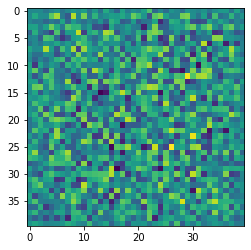

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch__0


100%|██████████| 938/938 [00:35<00:00, 26.33it/s]


1.3863642 0.69145125


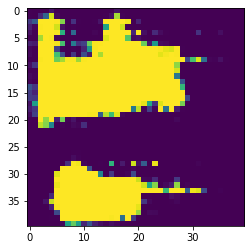

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch__1


100%|██████████| 938/938 [00:35<00:00, 26.74it/s]


1.3863294 0.692299


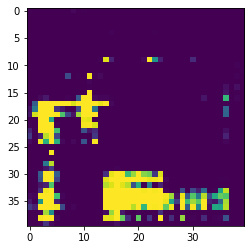

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch__2


100%|██████████| 938/938 [00:35<00:00, 26.52it/s]


1.3863176 0.6925817


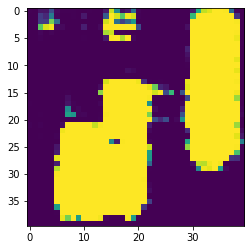

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch__3


100%|██████████| 938/938 [00:35<00:00, 26.47it/s]


1.3863119 0.692723


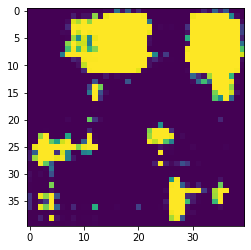

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch__4


100%|██████████| 938/938 [00:35<00:00, 26.58it/s]


1.3863083 0.6928079


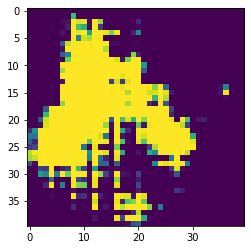

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch__5


100%|██████████| 938/938 [00:35<00:00, 26.55it/s]


1.386306 0.6928644


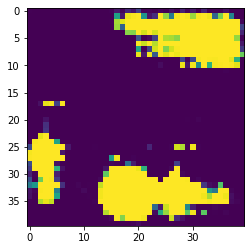

  0%|          | 2/938 [00:00<00:49, 19.03it/s]

Epoch__6


100%|██████████| 938/938 [00:35<00:00, 26.65it/s]


1.3863044 0.69290483


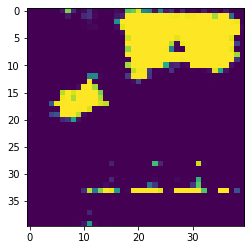

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch__7


100%|██████████| 938/938 [00:35<00:00, 26.27it/s]


1.3863033 0.692935


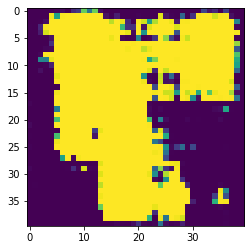

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch__8


100%|██████████| 938/938 [00:36<00:00, 25.77it/s]


1.3863024 0.6929585


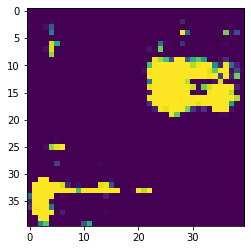

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch__9


100%|██████████| 938/938 [00:35<00:00, 26.24it/s]


1.3863015 0.69297737


In [12]:
tf.keras.backend.clear_session()
gen = Generator()
dis = Discriminator()
train(tr_ds, 10, gen, dis)

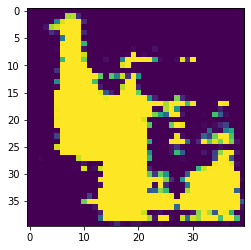

In [36]:
im = gen(tf.random.normal([64, 100]))
plt.imshow(im[0,:,:,0])